## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [5]:
import os
import keras
from keras.regularizers import l1, l2, l1_l2

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [6]:
train, test = keras.datasets.cifar10.load_data()

In [7]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [8]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

## L1_L2 正規化結果

In [12]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [17]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [14]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L1_L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l1_l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with Regulizer = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [====

50000/50000 [==============================] - 9s 181us/step - loss: 2.4614 - accuracy: 0.0986 - val_loss: 2.4612 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 9s 180us/step - loss: 2.4614 - accuracy: 0.0972 - val_loss: 2.4614 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 9s 175us/step - loss: 2.4614 - accuracy: 0.0965 - val_loss: 2.4612 - val_accuracy: 0.1000
Experiment with Regulizer = 0.000100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________

50000/50000 [==============================] - 10s 200us/step - loss: 1.7694 - accuracy: 0.4761 - val_loss: 1.7791 - val_accuracy: 0.4767
Epoch 46/50
50000/50000 [==============================] - 9s 189us/step - loss: 1.7653 - accuracy: 0.4777 - val_loss: 1.8168 - val_accuracy: 0.4623
Epoch 47/50
50000/50000 [==============================] - 9s 188us/step - loss: 1.7624 - accuracy: 0.4779 - val_loss: 1.8072 - val_accuracy: 0.4672
Epoch 48/50
50000/50000 [==============================] - 10s 193us/step - loss: 1.7596 - accuracy: 0.4785 - val_loss: 1.8013 - val_accuracy: 0.4585
Epoch 49/50
50000/50000 [==============================] - 10s 199us/step - loss: 1.7563 - accuracy: 0.4791 - val_loss: 1.8039 - val_accuracy: 0.4482
Epoch 50/50
50000/50000 [==============================] - 10s 195us/step - loss: 1.7531 - accuracy: 0.4795 - val_loss: 1.7861 - val_accuracy: 0.4647
Experiment with Regulizer = 0.000000
Model: "model_1"
____________________________________________________________

50000/50000 [==============================] - 10s 204us/step - loss: 1.6425 - accuracy: 0.5168 - val_loss: 1.7222 - val_accuracy: 0.4798
Epoch 43/50
50000/50000 [==============================] - 11s 211us/step - loss: 1.6384 - accuracy: 0.5190 - val_loss: 1.7075 - val_accuracy: 0.4927
Epoch 44/50
50000/50000 [==============================] - 11s 219us/step - loss: 1.6315 - accuracy: 0.5203 - val_loss: 1.6832 - val_accuracy: 0.4979
Epoch 45/50
50000/50000 [==============================] - 12s 245us/step - loss: 1.6273 - accuracy: 0.5228 - val_loss: 1.6820 - val_accuracy: 0.4994
Epoch 46/50
50000/50000 [==============================] - 11s 220us/step - loss: 1.6222 - accuracy: 0.5225 - val_loss: 1.6745 - val_accuracy: 0.5041
Epoch 47/50
50000/50000 [==============================] - 11s 212us/step - loss: 1.6195 - accuracy: 0.5253 - val_loss: 1.6700 - val_accuracy: 0.5053
Epoch 48/50
50000/50000 [==============================] - 11s 222us/step - loss: 1.6129 - accuracy: 0.5250 - va

50000/50000 [==============================] - 10s 204us/step - loss: 1.6702 - accuracy: 0.5077 - val_loss: 1.7121 - val_accuracy: 0.4894
Epoch 40/50
50000/50000 [==============================] - 10s 198us/step - loss: 1.6610 - accuracy: 0.5108 - val_loss: 1.7392 - val_accuracy: 0.4766
Epoch 41/50
50000/50000 [==============================] - 10s 193us/step - loss: 1.6526 - accuracy: 0.5105 - val_loss: 1.7072 - val_accuracy: 0.4920
Epoch 42/50
50000/50000 [==============================] - 10s 198us/step - loss: 1.6467 - accuracy: 0.5129 - val_loss: 1.7012 - val_accuracy: 0.4900
Epoch 43/50
50000/50000 [==============================] - 10s 196us/step - loss: 1.6418 - accuracy: 0.5139 - val_loss: 1.7083 - val_accuracy: 0.4849
Epoch 44/50
50000/50000 [==============================] - 10s 195us/step - loss: 1.6361 - accuracy: 0.5162 - val_loss: 1.6779 - val_accuracy: 0.5023
Epoch 45/50
50000/50000 [==============================] - 10s 191us/step - loss: 1.6323 - accuracy: 0.5168 - va

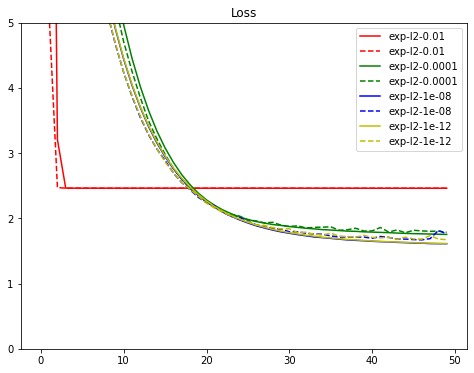

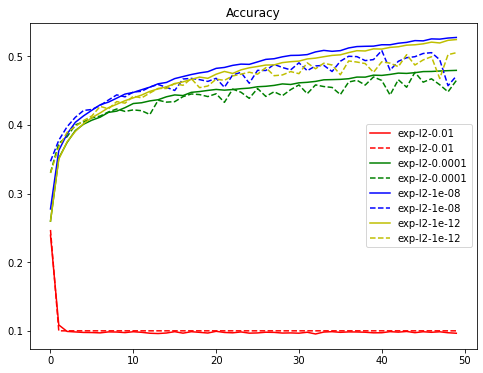

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

## L1 正規化結果

In [18]:
def build_l1_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [20]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L1_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_l1_mlp(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [====

50000/50000 [==============================] - 9s 186us/step - loss: 2.4626 - accuracy: 0.0976 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 9s 179us/step - loss: 2.4626 - accuracy: 0.1003 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 9s 179us/step - loss: 2.4626 - accuracy: 0.0968 - val_loss: 2.4624 - val_accuracy: 0.1000
Experiment with Regulizer = 0.000100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________

Epoch 46/50
50000/50000 [==============================] - 9s 172us/step - loss: 2.7816 - accuracy: 0.6263 - val_loss: 3.1325 - val_accuracy: 0.5008
Epoch 47/50
50000/50000 [==============================] - 9s 171us/step - loss: 2.7493 - accuracy: 0.6236 - val_loss: 3.0593 - val_accuracy: 0.5173
Epoch 48/50
50000/50000 [==============================] - 8s 170us/step - loss: 2.7171 - accuracy: 0.6258 - val_loss: 2.9353 - val_accuracy: 0.5393
Epoch 49/50
50000/50000 [==============================] - 8s 167us/step - loss: 2.6743 - accuracy: 0.6278 - val_loss: 2.9578 - val_accuracy: 0.5245
Epoch 50/50
50000/50000 [==============================] - 8s 169us/step - loss: 2.6413 - accuracy: 0.6273 - val_loss: 2.9980 - val_accuracy: 0.5052
Experiment with Regulizer = 0.000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
___

50000/50000 [==============================] - 9s 179us/step - loss: 0.9717 - accuracy: 0.6579 - val_loss: 1.4914 - val_accuracy: 0.5018
Epoch 44/50
50000/50000 [==============================] - 9s 181us/step - loss: 0.9578 - accuracy: 0.6621 - val_loss: 1.4156 - val_accuracy: 0.5253
Epoch 45/50
50000/50000 [==============================] - 9s 186us/step - loss: 0.9495 - accuracy: 0.6637 - val_loss: 1.3846 - val_accuracy: 0.5269
Epoch 46/50
50000/50000 [==============================] - 9s 182us/step - loss: 0.9394 - accuracy: 0.6682 - val_loss: 1.4094 - val_accuracy: 0.5220
Epoch 47/50
50000/50000 [==============================] - 10s 191us/step - loss: 0.9268 - accuracy: 0.6737 - val_loss: 1.4003 - val_accuracy: 0.5281
Epoch 48/50
50000/50000 [==============================] - 9s 181us/step - loss: 0.9090 - accuracy: 0.6803 - val_loss: 1.3826 - val_accuracy: 0.5263
Epoch 49/50
50000/50000 [==============================] - 8s 169us/step - loss: 0.9054 - accuracy: 0.6805 - val_loss

50000/50000 [==============================] - 9s 182us/step - loss: 0.9980 - accuracy: 0.6485 - val_loss: 1.3457 - val_accuracy: 0.5277
Epoch 41/50
50000/50000 [==============================] - 9s 182us/step - loss: 0.9796 - accuracy: 0.6553 - val_loss: 1.4448 - val_accuracy: 0.5109
Epoch 42/50
50000/50000 [==============================] - 9s 170us/step - loss: 0.9722 - accuracy: 0.6575 - val_loss: 1.4225 - val_accuracy: 0.5156
Epoch 43/50
50000/50000 [==============================] - 9s 172us/step - loss: 0.9608 - accuracy: 0.6615 - val_loss: 1.3595 - val_accuracy: 0.5341
Epoch 44/50
50000/50000 [==============================] - 9s 175us/step - loss: 0.9472 - accuracy: 0.6661 - val_loss: 1.4398 - val_accuracy: 0.5134
Epoch 45/50
50000/50000 [==============================] - 9s 174us/step - loss: 0.9357 - accuracy: 0.6701 - val_loss: 1.3910 - val_accuracy: 0.5305
Epoch 46/50
50000/50000 [==============================] - 9s 173us/step - loss: 0.9221 - accuracy: 0.6765 - val_loss:

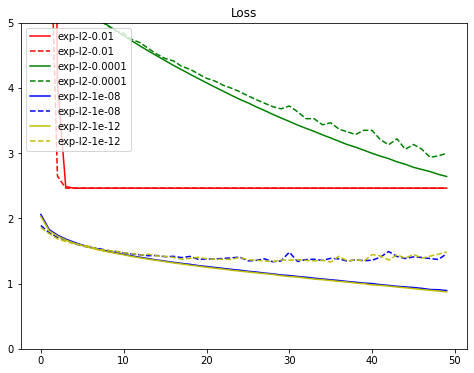

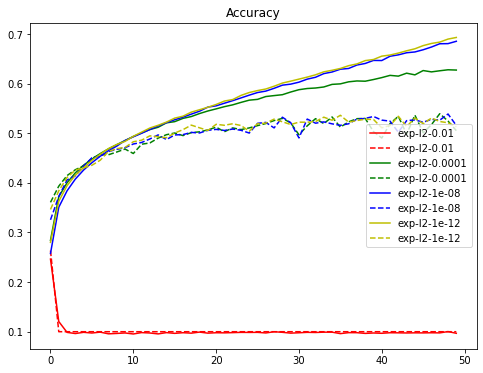

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()